# From normalized spectrum to Bz measurement

<img src="https://github.com/folsomcp/specpolFlow/blob/main/docs-jb/GetStarted/OneObservationFlow_tutorialfiles/diagram4.png?raw=true" align: center width="1000px">



In the below code, we will walk through how to use `SpecpolFlow` (with the use of [`LSDpy`](https://github.com/folsomcp/LSDpy)) with a single, normalized Stokes V spectrum for the magnetic B star $\xi^1$ CMa (HD 46328; [Erba et al. 2021](https://doi.org/10.1093/mnras/stab1454); ESPaDOnS). The code has the following structure:

0. Import packages
1. Star Selection
2. Creating the LSD Line Mask
3. Cleaning Line Mask
4. Creating LSD Profile
5. Extracting $B_{\text{z}}$

First, we need to import the packages:

In [1]:
# Importing pacakges

import pandas as pd
import specpolFlow as pol

## 1. Necessary information and files

To use this tutorial, you must start with a ***normalized spectrum*** in the so-called 'Donati' format (a *.s* file). If you do not have a *.s* file (you have *.fits* or .p files), please see the previous tutorial. 

1. Collect .s file. For this example, we provide the file ([hd46328_test_1.s](https://github.com/folsomcp/specpolFlow/blob/main/docs-jb/GetStarted/OneObservationFlow_tutorialfiles/hd46328_test_1.s)). 

::::{margin}
:::{note}
For our example, the stellar parameters of are: 
* $T_{\text{eff}}$ = 27000 K
* $\log g$ = 3.5 (cgs)
* $v\sin i$  = 15 km $\text{s}^{-1}$
* $\text{RV}$ = 12 km $\text{s}^{-1}$
:::
::::
2. Collect important stellar parameters:
    - $T_{\text{eff}}$, log $_g$ are necessary to obtain the line list for the LSD mask
    - You might also find it useful to have the $v\sin i$ and observation specific radial velocities (however these can be measured later on the the LSD profile). 


3. Next we will need to obtain a list of atomic and molecular transition parameters for this $T_{\text{eff}}$, log $_g$ from the Vienna Atomic Line Database (VALD; [Ryabchikova et al. 2015](https://ui.adsabs.harvard.edu/abs/2015PhyS...90e4005R/abstract)). The long list for this star is provided ([LongList_T27000G35.dat](https://github.com/folsomcp/specpolFlow/blob/main/docs-jb/GetStarted/OneObservationFlow_tutorialfiles/LongList_T27000G35.dat)), 

::::{admonition} Need to download your own line list?
:class: tip, dropdown
To retrieve a VALD long list, click the "Extract Stellar" button on the [VALD website](http://vald.astro.uu.se/).  
:::{Note} 
You need to register an email to access the site. 
:::
In our example, we use the following input to obtain the long list:
* Starting wavelength: 3700 Å
* Ending wavelength: 9000 Å
* Detection threshold: 0.01 (line depths shallower than this threshold are not included)
* Microturbulence: 2 km s$^{-1}$
* $T_{\text{eff}}$ = 27000 K
* $\log g$ = 3.5 (cgs)
* Chemical Composition: 0.0 [Fe/H] (Solar)
* Long format
* Linelist configuration: Default
::::

The long list file is a text file consisting of a header line containing information on the wavelength range of the list, as well as other information about the content of the file.

For each spectral line, there are two rows of information about the physical parameters like the energy levels involved, the measured Landé factors, etc. 

To create LSD profile, we need some specific information about each spectral lines, and the tools described in the next section will transform the VALD files into a Mask file. 


## 2. Creating LSD Line Mask

To convert the VALD long list file into a LSD line mask file, we use the `make_mask` function. 
We need to specify the location and name of the input VALD file and the output file

We will use the options `depthCutoff` (which only selects lines with depths greater than the specified value), and `atomsOnly` (`atomsOnly` = True excludes H lines). 
For additional options, please consult the [API](https://folsomcp.github.io/specpolFlow/API/Mask_API.html#specpolFlow.make_mask)

This will create a '.mask' file.

In [2]:
VALD_file_name = 'OneObservationFlow_tutorialfiles/LongList_T27000G35.dat'
file_output = 'OneObservationFlow_tutorialfiles/test_output/T27000G35_depth0.02.mask'
mask = pol.make_mask(VALD_file_name, outMaskName=file_output, depthCutoff = 0.02, atomsOnly = True)

missing Lande factors for 160 lines (skipped) from:
['He 2', 'O 2']
skipped all lines for species:
['H 1']


## 3. Cleaning the Line Mask 
Next, we remove sections in the mask that we do not want affecting the LSD profile. For example, these include:
- regions 400 km s$^{-1}$ (specific to this example) around the Balmer series
- the Balmer jump where the spectrum normalization is not great
- areas of large telluric contamination. 

We remove these sections because the lines are either of the wrong shape or the data is contaminated by the atmosphere; both would negativley effect later processing.

In this example, we will use `default` regions that are available in `SpecpolFlow`:
- We can exclude the Balmer using `get_Balmer_regions_default`. This function takes in the velocity region around the line center that you want to exclude. In our example, we will use 400 km/s on each side of the line, to exclude any other spectral lines that would be in the broad wings of the Balmer lines. 
- We can exclude the telluric regions with  `get_telluric_regions_default`. 

Then the `mask.clean` function removes the lines within regions specified. The clean mask can now be output to a new `.mask` file using the `mask.save` functionality.

In [3]:
# inputs
# user manual for telleric regions
velrange = 400 # units are in km/s
excluded_regions = pol.get_Balmer_regions_default(velrange) + pol.get_telluric_regions_default()

In [4]:
# visualization of excluded regions
pd.DataFrame(excluded_regions.to_dict())

,start,stop,type
0,655.405353,657.156647,Halpha
1,485.491365,486.788635,Hbeta
2,433.470866,434.629134,Hgamma
3,409.622728,410.717272,Hdelta
4,396.480287,397.539713,Hepsilon
5,360.000000,392.000000,Hjump
6,587.500000,592.000000,telluric
7,627.500000,632.500000,telluric
8,684.000000,705.300000,telluric
9,717.000000,735.000000,telluric


In [5]:
# location of the output file
clean_Mask_filename = 'OneObservationFlow_tutorialfiles/test_output/hd46328_test_depth0.02_clean.mask'

# run cleanMask fuction and save
mask.clean(excluded_regions).save(clean_Mask_filename)

:::{Tip}
For more information about the functionalities of the `Mask` and `ExcludeMaskRegion` class objects, see the tutorials:
- [How to use the Mask objects](https://folsomcp.github.io/specpolFlow/Tutorials/3-MaskClass_Tutorial.html)
- [How to use the ExcludeMaskRegion objects](https://folsomcp.github.io/specpolFlow/Tutorials/4-ExcludeMaskRegionClass_Tutorial.html)

For more information about an interactive tool to perform mask cleaning, see
- [How to clean masks with the interactive tool](https://folsomcp.github.io/specpolFlow/Tutorials/3b-MaskUI_Tutorial.html)
:::

## 4. Creating the LSD Profile

Least-Squares Deconvolution (LSD) is a cross-correlation technique for computing the weighted average of selected spectral lines ([Donati et al. 1997](https://ui.adsabs.harvard.edu/abs/1997MNRAS.291..658D/abstract)). 

::::{margin}
:::{tip}
For more information about how to transform your computed LSD profiles for other choices of weights, see the [](../Tutorials/5-LSDClass_Tutorial.ipynb) tutorial.
:::
::::
To compute an LSD profile, we need to define the normalizing weights that will be used. In this example, We use these commonly used values:
* normDepth = 0.2 — normalized line depth
* normLande = 1.2 — normalized effective Lande factor
* normWave = 500.0 — normalized wavelength

To capture the entire line profile, we set the range of the LSD profile to 100 km s$^{-1}$, because we know that the $v\sin i$ star is 15 km/s. 

Additionally, the pixel size should be set relative to the resolution and pixel size of the data; for ESPaDOnS data, we should not go below the 1.8 km/s pixel size. In a case where the line profile is very broad, it may be advantageous to use larger pixels, it is important to make sure the profile is sampled with enough datapoints. For our example, we use 2.6 km s$^{-1}$ per pixel.

To calculate the LSD profile, we call the <a href='../API/LSD_API.html#specpolFlow.run_lsdpy'>`run_lsdpy` </a> function.

:::{warning}
The <a href='../API/LSD_API.html#specpolFlow.run_lsdpy'>`run_lsdpy` </a> function only works using the mask (.mask) and spectrum (.s) *files* as input: you cannot pass an already loaded <a href='../API/LSD_API.html#specpolFlow.Spectrum'>Spectrum</a> or <a href='../API/LSD_API.html#specpolFlow.Mask'>Mask</a> objects as input. 
:::

The <a href='../API/LSD_API.html#specpolFlow.run_lsdpy'>`run_lsdpy` </a> return an <a href='../API/LSD_API.html#specpolFlow.LSD'>LSD</a> object, as well as the model spectrum as a <a href='../API/LSD_API.html#specpolFlow.Spectrum'>Spectrum</a> object. 

In the below code, we also specified the name and location for saving the LSD profile into a file (.lsd). 

We leave all of the other parameters to their default values. For full description of LSDpy options, see [LSDpy](https://github.com/folsomcp/LSDpy).

Modified line mask, removed 73 too closely spaced lines
Average observed spec velocity spacing: 1.810029 km/s
using a 78 point profile with 2.600000 km/s pixels
mean mask depth 0.101933 wl 494.631 Lande 1.181853 (from 1016 lines)
mean mask norm weightI 0.509665 weightV 0.484676
saving model spectrum to  ...
I reduced chi2 244.9679 (chi2 18799572.60 constraints 76821 dof 78)
 Rescaling error bars by: 15.651451
V reduced chi2 1.1250 (chi2 86332.12 constraints 76821 dof 78)
 Rescaling error bars by: 1.060637
 removing profile continuum pol: -8.0994e-06 +/- 8.5239e-09 (avg err 9.2041e-05)
N1 reduced chi2 1.1035 (chi2 84686.04 constraints 76821 dof 78)
 Rescaling error bars by: 1.050477
 removing profile continuum pol: -9.5105e-07 +/- 8.3614e-09 (avg err 9.1160e-05)
(possible Stokes I uncertainty underestimate 2.0234e-03 vs 1.4214e-03)
line range estimate -14.200000000000188 42.99999999999969 km/s
V in line reduced chi^2 90.219068 (chi2 1984.819495) 
 detect prob 1.000000 (fap 0.000000e+00)

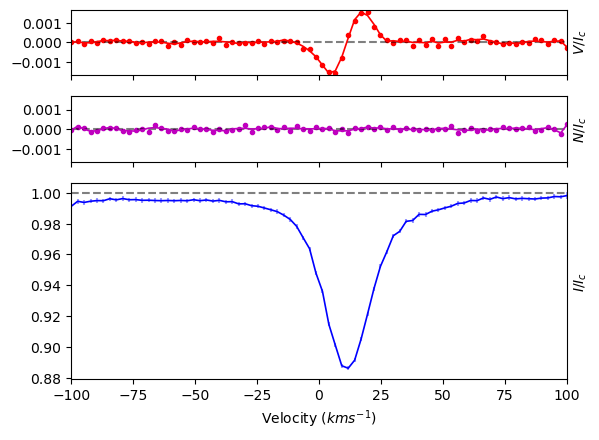

In [6]:
clean_Mask_filename = 'OneObservationFlow_tutorialfiles/test_output/hd46328_test_depth0.02_clean.mask'
spectrum = 'OneObservationFlow_tutorialfiles/hd46328_test_1.s'

LSD_outfile = 'OneObservationFlow_tutorialfiles/test_output/hd46328_test_1.lsd'

lsd, mod = pol.run_lsdpy(obs = spectrum, mask = clean_Mask_filename, outLSDName = LSD_outfile, 
           velStart =- 100.0, velEnd = 100.0, velPixel = 2.6, 
           normDepth = 0.2, normLande = 1.2, normWave = 500.0)

:::{tip}
If you are e.g. making tests and do not need to save the resulting LSD profiles to files just yet, simply keep the returned LSD profile and Model Spectrum into variables and don't set the `outLSDName` and `outModelName`keywords. You can save later on with the <a href='../API/LSD_API.html#specpolFlow.LSD'>`LSD`</a> class <a href='../API/LSD_API.html#specpolFlow.LSD.save'>`save`</a> function. 
```
lsd, mod = pol.run_lsdpy(obsFile, maskFile, ...)

[more manipulation of the lsd object]

lsd.save('Name of file')
```

If you are e.g. only interested in generating LSD files and do not need to do further manipulations futher in the code, then you do not have to store the returned LSD object and Model Spectrum object to a variable.
```
pol.run_lsdpy(obsFile, maskFile, outLSDName='Name of File', outModelName='Name of file')
```
::: 


## 5. Calculate $B_z$ from LSD Profile

To calculate the longitudinal field $B_z$ from our LSD profile, we will be using the <a href='../API/LSD_API.html#specpolFlow.LSD.calc_bz'>`calc_bz` </a> function of the <a href='../API/LSD_API.html#specpolFlow.LSD'>`LSD` </a> class. 

To compute $B_z$, we need to know the velocity (or center-of-gravity 'cog') of the center of the spectral line and the characteristics of the line ($\lambda_0$, $g_\mathrm{eff}). It is also customary to renormalize the LSD profile to the continuum surrounding the line. 

In our first example, we will use the default built-in methods to compute the cog (`cog='I'`) and the continnum normalization (`norm='auto'`).

This function requires some additional information. 

:::{warning}
VERO STILL WORKING ON THIS SECTION
:::


* cog - the center of gravity; this can either be set manually or calculated from one of the built-in functions (see the [](../Tutorials/6-CalculateBz_Tutorial.ipynb) tutorial or the API for more information on the options)

* velrange - range of velocity to use for the determination of the cog is using a built-in method and to exclude in the normalization if using the normalization 'auto' method. 

* plot - a flag that determines if an output plot will be automatically generated
* bzwidth - the range over which the Bz will be calculated; this should just include the line itself (if given a single number it will center the range on the cog value)

In the first example we are manually setting the velocity range and Bz width, however it is often useful to set the velocity range slightly larger than the $v\sin i$ and shifted to be centered on the cog value. By these standards, for this example, velrange _*would*_ be `velrange=[12-1.5*vsini,12+1.5*vsini]` and bzwidth _*would*_ be `bzwidth=vsini`. 

In the second example the cog value is being set automatically using the I method. 

The function will then output a dictionary with the following outputs:
* Ic: continuum value used for normalization
* Cog: the center of gravity value
* Bzwidth min (km $s^{-1}$): lower bound of the Bz width
* Bzwidth max (km $s^{-1}$): upper bound of Bz width
* V bz (G): Bz calculated from Stokes V profile
* V bz sig (G): standard deviation
* V FAP: false alarm probability [FAP (Donati et al. 1997)](https://ui.adsabs.harvard.edu/abs/1997MNRAS.291..658D/abstract). Definite detection (DD) is defined as having a FAP $< 10^{-5}$. A non-detection (ND) is defined as having a FAP $> 10^{-3}$. FAPs between $10^{-5}$ and $10^{-3}$ are defined as a marginal detection (MD).
* Null calculations - N1 and N2 are two different methods for null profile calculations; N1 is most commonly used.
    * N1 bz (G): Bz calculated from the Null 1 profile
    * N1 bz sig (G): standard deviation
    * N1 FAP: false alarm probability of Null 1 Bz measurement
    * N2 bz (G): Bz calculated from the Null 2 profile
    * N2 bz sig (G): standard deviation
    * N2 FAP: false alarm probability of Null 2 Bz measurement
    
To see additional capabilities of the Bz function, see [SpecpolFlow](https://github.com/folsomcp/specpolFlow) or for a more detailed tutorial, see the [Bz tutorial](https://github.com/folsomcp/specpolFlow/blob/main/tutorials/CalculateBz.ipynb).

using AUTO method for the normalization
  using the median of the continuum outside of the line


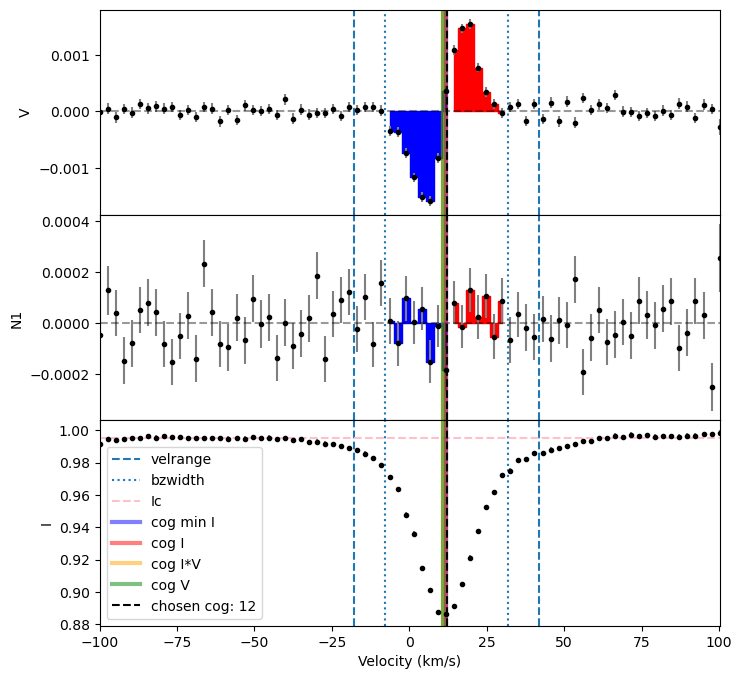

In [7]:
LSD_outfile = 'OneObservationFlow_tutorialfiles/test_output/hd46328_test_1.lsd'

# Bz calculation using manual cog selection
vrad = 12
velrange = [-18,42] # the velocity range over which the center line is found
bzwidth = 20 # this is the width about the center line used to calculate Bz

lsd = pol.read_lsd(LSD_outfile)
Bz, fig = lsd.calc_bz(cog = vrad, velrange = velrange, bzwidth = bzwidth,
                      plot = True, figsize=(8,8))

In [8]:
# the below dataframe contains the defaults outputs
pd.DataFrame(data=[Bz])

,Ic,cog,Bzwidth min,Bzwidth max,V bz (G),V bz sig (G),V FAP,N1 bz (G),N1 bz sig (G),N1 FAP,N2 bz (G),N2 bz sig (G),N2 FAP
0,0.994963,12,-8,32,-112.658484,4.148896,0.0,-3.746074,4.069664,0.274214,0.0,0.0,0.0


using AUTO method for the normalization
  using the median of the continuum outside of the line


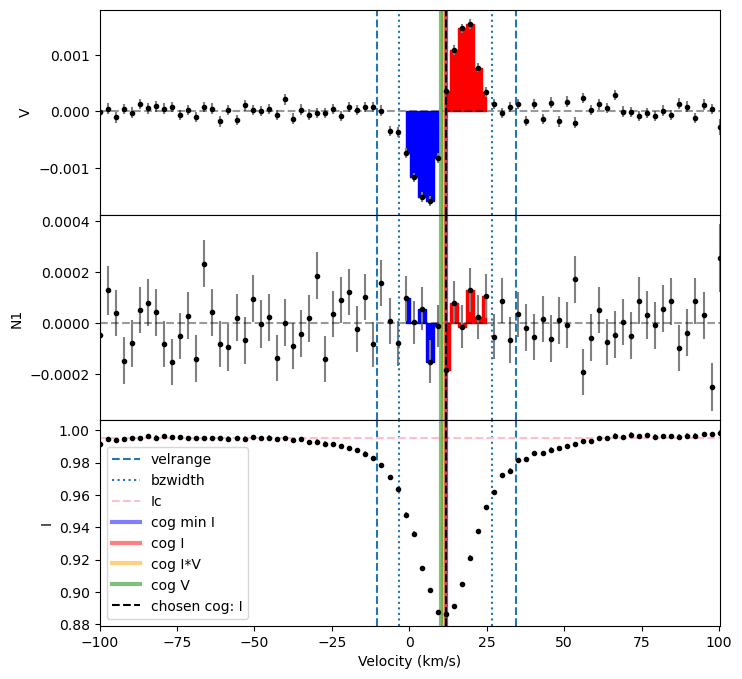

In [9]:
# Bz calculation using automatic cog selection (I)
vsini = 15
vrad = 12

lsd = pol.read_lsd(LSD_outfile)
Bz, fig = lsd.calc_bz(cog = 'I', velrange = [(vrad-1.5*vsini),(vrad+1.5*vsini)], bzwidth = vsini,
                      plot = True, figsize=(8,8))

In [10]:
pd.DataFrame(data=[Bz])

,Ic,cog,Bzwidth min,Bzwidth max,V bz (G),V bz sig (G),V FAP,N1 bz (G),N1 bz sig (G),N1 FAP,N2 bz (G),N2 bz sig (G),N2 FAP
0,0.99485,11.681664,-3.318336,26.681664,-105.107513,2.829525,0.0,-2.659136,2.755427,0.154686,0.0,0.0,0.0
